In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import concurrent.futures
import tensorflow as tf
import numpy as np
import random
import math

# Image manipulation.
import PIL.Image
from scipy.ndimage.filters import gaussian_filter
from IPython.display import Image, display

# for the download module which is used by inception5h
import sys
sys.path.append('..')

In [2]:
import inception5h
inception5h.maybe_download()
model = inception5h.Inception5h()

Data has been already downloaded and unpacked


In [3]:
# helper functions for image manipulation
def load_image(filename):
    image = PIL.Image.open(filename)
    return np.float32(image)

def save_image(image, filename):
    image = np.clip(image, 0.0, 255.0)
    image = image.astype(np.uint8)
    
    with open(filename, 'wb') as file:
        PIL.Image.fromarray(image).save(file, 'jpeg')

def plot_image(image):
    image = np.clip(image, 0.0, 255.0)
    image = image.astype(np.uint8)
    
    display(PIL.Image.fromarray(image))

def normalize_image(image):
    i_min = image.min()
    i_max = image.max()
    x_norm = (image - i_min) / (i_max - i_min)
    return x_norm

def plot_gradient(gradient):
    gradient_norm = normalize_image(gradient)
    plt.imshow(gradient_norm, interpolation='bilinear')
    plt.show()

def resize_image(image, size=None, factor=None):
    # If a rescaling-factor is provided then use it.
    if factor is not None:
        # Scale the numpy array's shape for height and width.
        size = np.array(image.shape[0:2]) * factor
        
        # The size is floating-point because it was scaled.
        # PIL requires the size to be integers.
        size = size.astype(int)
    else:
        # Ensure the size has length 2.
        size = size[0:2]
    
    # The height and width is reversed in numpy vs. PIL.
    size = tuple(reversed(size))

    # Ensure the pixel-values are between 0 and 255.
    img = np.clip(image, 0.0, 255.0)
    
    # Convert the pixels to 8-bit bytes.
    img = img.astype(np.uint8)
    
    # Create PIL-object from numpy array.
    img = PIL.Image.fromarray(img)
    
    # Resize the image.
    img_resized = img.resize(size, PIL.Image.LANCZOS)
    
    # Convert 8-bit pixel values back to floating-point.
    return np.float32(img_resized)

# Deep-dream algorithm
## Gradient

In [4]:
def get_tile_size(num_pixels, tile_size=400):
    num_tiles = int(round(num_pixels / tile_size))
    num_tiles = max(1, num_tiles)
    return math.ceil(num_pixels / num_tiles)

def tiled_gradient(gradient, image, tile_size=400):
    grad = np.zeros_like(image)
    
    x_max, y_max, _ = image.shape
    
    x_tile_size = get_tile_size(x_max, tile_size)
    x_tile_size4 = x_tile_size // 4

    y_tile_size = get_tile_size(y_max, tile_size)
    y_tile_size4 = y_tile_size // 4

    x_start = random.randint(-3 * x_tile_size4, -x_tile_size4)
    
    while x_start < x_max:
        x_end = x_start + x_tile_size
        
        x_start_lim = max(x_start, 0)
        x_end_lim = min(x_end, x_max)
        
        y_start = random.randint(-3 * y_tile_size4, -y_tile_size4)
        
        while y_start < y_max:
            y_end = y_start + y_tile_size
            
            y_start_lim = max(y_start, 0)
            y_end_lim = min(y_end, y_max)
            
            img_tile = image[x_start_lim:x_end_lim, y_start_lim:y_end_lim]
            feed_dict = model.create_feed_dict(img_tile)
            
            g = session.run(gradient, feed_dict=feed_dict)
            
            # normalize
            g /= (np.std(g) + 1e-8)
            
            grad[x_start_lim:x_end_lim, y_start_lim:y_end_lim] = g
            y_start = y_end

        x_start = x_end

    return grad

## Optimize image

In [5]:
def optimize_image(layer_tensor, image,
                   num_iter=10, step_size=3.0, tile_size=400,
                   show_gradient=False, save_images=False):
    img = image.copy()
    
    print('Image before:')
    plot_image(img)
    
    gradient = model.get_gradient(layer_tensor)
    
    if save_images:
        executor = concurrent.futures.ThreadPoolExecutor(max_workers=1)
    
    for i in range(num_iter):
        grad = tiled_gradient(gradient, img, tile_size)
        
        sigma = (i * 4.0) / num_iter + 0.5
        grad_smooth1 = gaussian_filter(grad, sigma=sigma)
        grad_smooth2 = gaussian_filter(grad, sigma=sigma * 2)
        grad_smooth3 = gaussian_filter(grad, sigma=sigma * 0.5)
        
        grad = (grad_smooth1 + grad_smooth2 + grad_smooth3)
        
        step_size_scaled = step_size / (np.std(grad) + 1e-8)
        
        img += grad * step_size_scaled
        
        if show_gradient:
            msg = 'Gradient min: {0:>9.6f}, max: {1:>9.6f}, stepsize: {2:>9.2f}'
            print(msg.format(grad.min(), grad.max(), step_size_scaled))
            plot_gradient(grad)
        else:
            end_msg = ' {0:03d}: {1:>9.6f}/{2:>9.6f}/{3:>4.2f}\n'
            print('.', end=end_msg.format(i, grad.min(), grad.max(), step_size_scaled) if i % 30 == 0 else '')

        # save images in another thread
        if save_images:
            executor.submit(save_image, img, '/tmp/deep-dream/image{0:04d}.jpeg'.format(i))

    print('\nImage after:')
    plot_image(img)
    
    return img
        

In [6]:
# tensorflow session
session = tf.InteractiveSession(graph=model.graph)

In [7]:
image = load_image('../images/shepherd-dog.jpg')
layer_tensor = model.layer_tensors[10]

Image before:


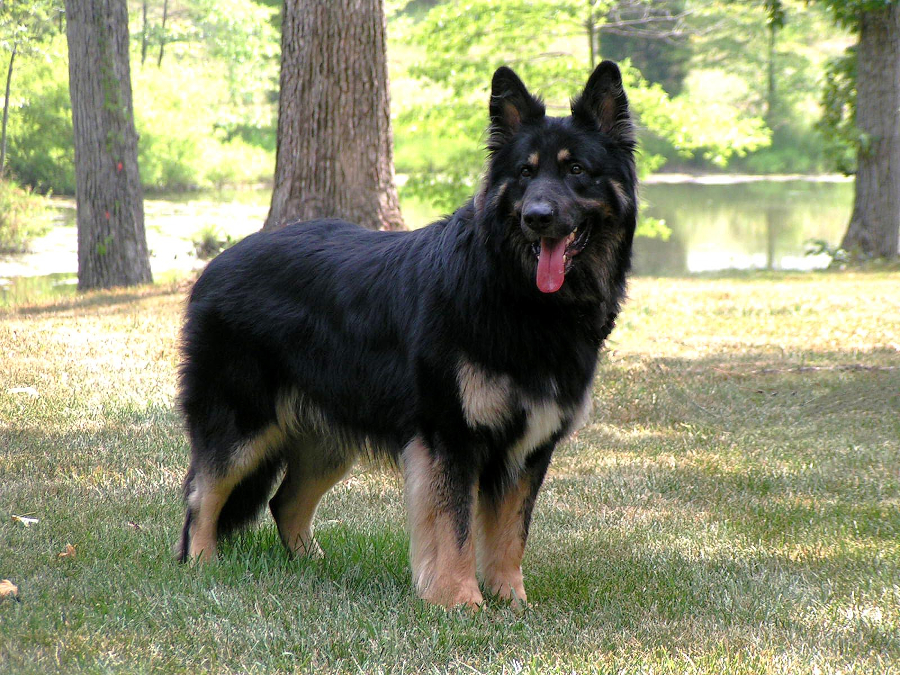

. 000: -58.650757/61.975723/1.67
.............................. 030: -17.736044/22.737514/2.19
.............................. 060: -15.467710/14.684354/2.95
.............................. 090: -8.474016/ 8.922142/3.99
.............................. 120: -7.292591/ 6.918911/5.15
.............................. 150: -5.557568/ 4.678060/6.43
.............................. 180: -4.123907/ 6.892770/7.83
.............................. 210: -3.895339/ 3.844666/9.38
.............................. 240: -2.736484/ 3.793481/10.94
.............................. 270: -2.686512/ 2.350475/12.71
.............................. 300: -2.381708/ 2.107634/14.62
.............................. 330: -1.872364/ 1.895508/16.93
.............................. 360: -1.454829/ 1.490175/18.53
.............................. 390: -1.335991/ 1.146217/21.15
.............................. 420: -1.035685/ 1.192060/23.12
.............................. 450: -0.981254/ 0.955802/25.21
.............................. 480: -0.949

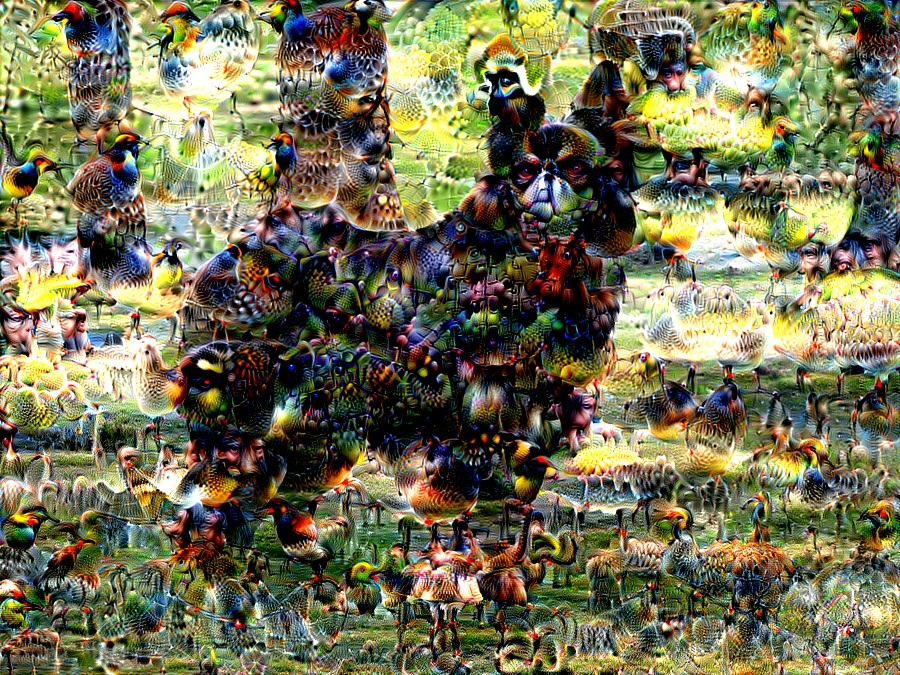

In [8]:
# use 'ffmpeg -r 4 -i image%04d.jpeg -vcodec h264_nvenc -y <output>' to build the video
img_result = optimize_image(layer_tensor, image,
                            num_iter=600, step_size=3.0, tile_size=400,
                            show_gradient=False, save_images=True)

In [9]:
session.close()